# Base regression tests
The object of our base regression tools is to provide an easy way to train and test models, automatically including standard covariates and properly handling cross validation issues. In many cases you can set up a regression test with just a few lines of code.

There are four main items of documentation for the base regression tools:

1. This tutorial notebook works through a series of examples of how these tools work, from a simple three line example to more complex configurations.
2. There is a [notebook](http://10.6.39.8:8888/notebooks/Users/Peter/Sample2.ipynb) which uses these tools to generate our production eye color models.
3. There is [online API documentation.](http://jarvis.hli.io/~pgarst/datastack/datastack/)
4. There is an [options notebook](http://10.6.39.8:8888/notebooks/MLOptions.ipynb) which provides a brief summary of the principle methods and options as a quick reference for those already familiar with the basic ideas.

This notebook exercises the BaseRegress class and shows how to do standard regressions in a few lines of code. We can explain a lot if we know age, gender and ethnicity, so the baseline tests always use that information.

We will show the following things:

1. [Find the standard baseline regressions](#sec1) for a phenotype value in Rosetta in a few lines of code.
2. If you have [multiple regression targets](#sec2), like right and left hand strength, find regressions for all of them and put the results in a single table.
3. Define as many [different sets of covariates](#sec3) as you like and run them all. We'll define size and eye color covariate sets, each containing a number of values from Rosetta, and see how well they predict hand strength.
4. There are a number of [display options](#sec3a) which help you show the data as you like it.
5. You can try [different estimators](#sec4) on a covariate set, for example lasso as well as ridge, or provide your own.
6. You can [add more error metrics](#sec5) to the standard list. For example, in a classification task you might want to add a "top two" accuracy value as another column.
7. [Provide more data](#sec6) in one or more data frames. This is useful for genomic data, and for features which you have processed and computed.
8. [Classification](#sec7) is very much like regression, but with different error metrics and default estimators.
9. You can [modify baseline covariates](#sec8) for age, gender and so on if you want.
10. There is a lot of [other information](#sec9) available from these tests, and we explore some of it.
11. The library also supplies a [shuffle test](#sec10) which allows you to collect statistics on estimator error rates. For example, you can use this to get a training curve, showing how error rates change as the size of the training set changes.

In [1]:
import datastack.dbs.rdb
import datastack.ml.baselines as baselines
import datastack.ml.baseregress as baseregress
import datastack.ml.baseclassify as baseclassify
import datastack.ml.cross_validation as cross_validation
import datastack.utilities.gui as gui
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
import sklearn.metrics as metrics

%matplotlib inline

## 1. <a id='sec1'></a>Get standard regression results for a measurement in Rosetta
The first task: given a feature in Rosetta, for example right hand strength, regress it against the standard baseline covariates.

In [2]:
base = baseregress.BaseRegress('facepheno.hand.strength.right.m1')
base.run()
base.display()

Model,Covariates,R2,MAE,MSE,Samples,MAE-signif,MSE-signif
Mean,,0.000,8.791,122.127,837.000,,
Median,,-0.026,8.658,125.268,837.000,,
Ridge,Age,0.038,8.604,117.538,837.000,,*
Ridge,Gender,0.427,6.479,69.981,837.000,**,**
Ridge,Ethnicity,0.019,8.649,119.755,837.000,,
Ridge,AGE,0.443,6.355,67.997,837.000,*,*


The baseline material includes just using the mean and median, and regressing the value against age, gender and ethnicity. The last line is an acronym for Age, Gender and Ethnicity - get it?

As we'll see, you could also pass in a dataframe with the information if the target of the regression is not available in Rosetta already.

You can get the exact specification for what these covariates are:

In [3]:
base.covariates['Gender']

['dynamic.FACE_P.gender.v1.value']

## 2. <a id='sec2'></a>Get results for multiple targets
We often want to regress several variables. In this section we model left and right hand strength separately, but still use the same covariates and put the results in the same table.

The targets can be the name of one value, as in the last section, or a list of names, or, as in this case, a dictionary which gives shorter and often more meaningful names for the targets.

In [4]:
targets = {'right':'facepheno.hand.strength.right.m1', 'left':'facepheno.hand.strength.left.m1'}

In [5]:
base2 = baseregress.BaseRegress(targets)
base2.run()
base2.display()

Model,Covariates,right: R2,right: MAE,right: MSE,left: R2,left: MAE,left: MSE,Samples
Mean,,0.000,8.791,122.127,0.000,9.091,131.068,837.000
Median,,-0.026,8.658,125.268,-0.048,8.943,137.333,837.000
Ridge,Age,0.038,8.604,117.538,0.031,8.874,127.037,837.000
Ridge,Gender,0.427,6.479,69.981,0.438,6.621,73.611,837.000
Ridge,Ethnicity,0.019,8.649,119.755,0.004,9.029,130.529,837.000
Ridge,AGE,0.443,6.355,67.997,0.448,6.545,72.320,837.000


As you see, we get one set of columns for the right hand feature and one set for the left. 

## 3. <a id='sec3'></a>Test our own features on these targets
The covariates field is a dictionary. You can add as many covariate lists as you want. In this example we define one set of covariates representing the size of the subject - height and bmi - and one representing eye color. Which do you think will better predict hand strength?

In [6]:
size = ['facepheno.height', 'dynamic.FACE.pheno.v1.bmi']
eyecolor = ['dynamic.FACE.eyecolor.v1_visit1.*']

In [7]:
base2 = baseregress.BaseRegress(targets)
base2.covariates['size'] = size
base2.covariates['eyecolor'] = eyecolor
base2.run()
base2.display()

Model,Covariates,right: R2,right: MAE,right: MSE,left: R2,left: MAE,left: MSE,Samples
Mean,,0.000,8.797,122.121,0.000,9.095,130.153,787.000
Median,,-0.026,8.660,125.324,-0.056,8.930,137.436,787.000
Ridge,Age,0.038,8.594,117.509,0.028,8.864,126.496,787.000
Ridge,Gender,0.424,6.473,70.352,0.437,6.579,73.251,787.000
Ridge,Ethnicity,0.021,8.645,119.539,0.007,9.010,129.305,787.000
Ridge,AGE,0.440,6.357,68.430,0.448,6.485,71.799,787.000
Ridge,AGE + eyecolor,0.436,6.375,68.839,0.446,6.496,72.055,787.000
Ridge,AGE + size,0.512,5.921,59.593,0.499,6.196,65.258,787.000
Ridge,eyecolor,0.014,8.661,120.378,0.004,9.060,129.687,787.000
Ridge,size,0.400,6.616,73.274,0.349,7.118,84.715,787.000


You won't be surprised to see that size is a decent predictor of hand strength (although not quite as good as gender), but eye color is unrelated.

Note that we used a regular expression to specify the eye color covariates.

## 4. <a id='sec3a'></a>Display options

There are a number of optional parameters to the display method which allow you to customize the output.

The number of digits of precision is configurable. You can pass a formatting dictionary to the display routine which gives the number of digits of precision for columns which contain the specified substring. We'll probably generalize this in the future.

### Specify precision for columns
For example, we can get more precision for all the MAE columns:

In [8]:
fmt = {}
fmt['MAE'] = 5
base2.display(fmtdict=fmt)

Model,Covariates,right: R2,right: MAE,right: MSE,left: R2,left: MAE,left: MSE,Samples
Mean,,0.000,8.79697,122.121,0.000,9.09500,130.153,787.000
Median,,-0.026,8.66010,125.324,-0.056,8.93011,137.436,787.000
Ridge,Age,0.038,8.59394,117.509,0.028,8.86403,126.496,787.000
Ridge,Gender,0.424,6.47277,70.352,0.437,6.57856,73.251,787.000
Ridge,Ethnicity,0.021,8.64536,119.539,0.007,9.00951,129.305,787.000
Ridge,AGE,0.440,6.35729,68.430,0.448,6.48493,71.799,787.000
Ridge,AGE + eyecolor,0.436,6.37522,68.839,0.446,6.49569,72.055,787.000
Ridge,AGE + size,0.512,5.92066,59.593,0.499,6.19566,65.258,787.000
Ridge,eyecolor,0.014,8.66138,120.378,0.004,9.05995,129.687,787.000
Ridge,size,0.400,6.61643,73.274,0.349,7.11847,84.715,787.000


### Skipping some rows
These tools can generate an inordinate number of rows, and we may not want to see them all.

If you know just what you want to test, you may not want the AGE + covariate rows. On the other hand, if your object is to see if any of the covariate sets add anything to what the AGE variables already tell us, you may want results for your covariates only in conjunction with the AGE variables.

The first option is available by specifying the optional rows parameter as 'noage'.

In [9]:
base2.display(rows='noage')

Model,Covariates,right: R2,right: MAE,right: MSE,left: R2,left: MAE,left: MSE,Samples
Mean,,0.000,8.797,122.121,0.000,9.095,130.153,787.000
Median,,-0.026,8.660,125.324,-0.056,8.930,137.436,787.000
Ridge,Age,0.038,8.594,117.509,0.028,8.864,126.496,787.000
Ridge,Gender,0.424,6.473,70.352,0.437,6.579,73.251,787.000
Ridge,Ethnicity,0.021,8.645,119.539,0.007,9.010,129.305,787.000
Ridge,AGE,0.440,6.357,68.430,0.448,6.485,71.799,787.000
Ridge,eyecolor,0.014,8.661,120.378,0.004,9.060,129.687,787.000
Ridge,size,0.400,6.616,73.274,0.349,7.118,84.715,787.000


The second option is available by specifying rows as 'age'. We'll add more options in the future.

In [10]:
base2.display(rows='age')

Model,Covariates,right: R2,right: MAE,right: MSE,left: R2,left: MAE,left: MSE,Samples
Mean,,0.000,8.797,122.121,0.000,9.095,130.153,787.000
Median,,-0.026,8.660,125.324,-0.056,8.930,137.436,787.000
Ridge,Age,0.038,8.594,117.509,0.028,8.864,126.496,787.000
Ridge,Gender,0.424,6.473,70.352,0.437,6.579,73.251,787.000
Ridge,Ethnicity,0.021,8.645,119.539,0.007,9.010,129.305,787.000
Ridge,AGE,0.440,6.357,68.430,0.448,6.485,71.799,787.000
Ridge,AGE + eyecolor,0.436,6.375,68.839,0.446,6.496,72.055,787.000
Ridge,AGE + size,0.512,5.921,59.593,0.499,6.196,65.258,787.000


If all else fails, metrics_df is the frame which the tools are displaying. You can pull this out of the BaseRegress object, filter and modify it as much as you like, and then pass it back into the display module.

The run method also has an optional with_aggregate_covariates parameter. If you set this to False, the tools won't do any of the regressions with AGE plus your covariate sets. If this choice meets your needs, it is faster than modifying the display properties because it turns off calculation of some results, not just display. To make this notebook faster and more compact we'll do this for the rest of the notebook.

### Skipping lots of rows
You may want to run and print just one row or a few. This is like running the underlying tools on one set of covariates, without giving up some of the support functions like integrating different data sources.

The run function takes a run_keys parameter which allows you to specify just the rows you want. For example:

In [11]:
size = ['facepheno.height', 'dynamic.FACE.pheno.v1.bmi']
eyecolor = ['dynamic.FACE.eyecolor.v1_visit1.*']

base2 = baseregress.BaseRegress(targets)
base2.covariates['size'] = size
base2.covariates['eyecolor'] = eyecolor
base2.run(run_keys=['size', 'eyecolor'])
base2.display()

Model,Covariates,right: R2,right: MAE,right: MSE,left: R2,left: MAE,left: MSE,Samples
Ridge,eyecolor,0.014,8.661,120.378,0.004,9.060,129.687,787.000
Ridge,size,0.400,6.616,73.274,0.349,7.118,84.715,787.000


### Dropping specified columns
You can drop columns from the table if you want. For example, we may think including MAE and MSE is too much. This is how we drop MSE. Note that we must set this before we run, not just at display time.

In [12]:
base2.dropCol('MSE')
base2.run()
base2.display(rows='noage')

Model,Covariates,right: R2,right: MAE,left: R2,left: MAE,Samples
Mean,,0.000,8.797,0.000,9.095,787.000
Median,,-0.026,8.660,-0.056,8.930,787.000
Ridge,Age,0.038,8.594,0.028,8.864,787.000
Ridge,Gender,0.424,6.473,0.437,6.579,787.000
Ridge,Ethnicity,0.021,8.645,0.007,9.010,787.000
Ridge,AGE,0.440,6.357,0.448,6.485,787.000
Ridge,eyecolor,0.014,8.661,0.004,9.060,787.000
Ridge,size,0.400,6.616,0.349,7.118,787.000


## 5. <a id='sec4'></a>Try different estimators on a covariate set
By default the baseline regression material uses a ridge regression method for regression, and logistic regression for classification. You can specify a list of other estimators if you want to do something different, or in addition.

Note that the estimators you specify are not used directly to fit the data, but are passed to the sklearn grid search method to look for good parameters.

As before, we define covariate sets. For the size covariates, we will also ask for both ridge and lasso estimators.

In [13]:
base = baseregress.BaseRegress(targets)

params = {'alpha': [ 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
est0 = {'est' : linear_model.Ridge()}
est1 = {'est' : linear_model.Lasso(), 'params' : params}
base.estimatorsToRun['size'] = [est0, est1]

base.covariates['size'] = size
base.covariates['eyecolor'] = eyecolor
base.run(with_aggregate_covariates=False)
base.display()

Model,Covariates,right: R2,right: MAE,right: MSE,left: R2,left: MAE,left: MSE,Samples
Mean,,0.000,8.797,122.121,0.000,9.095,130.153,787.000
Median,,-0.026,8.660,125.324,-0.056,8.930,137.436,787.000
Ridge,Age,0.038,8.594,117.509,0.028,8.864,126.496,787.000
Ridge,Gender,0.424,6.473,70.352,0.437,6.579,73.251,787.000
Ridge,Ethnicity,0.021,8.645,119.539,0.007,9.010,129.305,787.000
Ridge,eyecolor,0.014,8.661,120.378,0.004,9.060,129.687,787.000
Ridge,size,0.400,6.616,73.274,0.349,7.118,84.715,787.000
Lasso,size,0.397,6.628,73.625,0.349,7.118,84.718,787.000


As you see, the BaseRegress object has another dictionary called estimatorsToRun. It shares keys with the covariates dictionary, so to try different estimators for a given covariates set you assign a list of estimators to this key.

In this case you see we are running two estimators for the size covariates, a ridge estimator and a lasso estimator. We wind up with two rows for the size covariates, one for each estimator.

We specify each estimator, and also the set of parameters for the estimator which we want to try in the grid search. Each estimator is specified by a dictionary, in which the 'est' entry is the estimator itself. If you supply a params entry also, the sklearn grid search code will try all the values you supply. If you omit the params value, the library will use a default set of parameters. If you know the values you want for the parameters like the alpha regularization value in this test, you can supply them in the estimator constructor and use an empty dictionary for the params value.

## 6. <a id='sec5'></a>Add custom error columns
As you have seen the BaseRegress class computes a number of standard quality measures for each estimation task. You may want to add other quality measures.

The object has an "extracols" dictionary which allows you to add extra columns. The key is the name of the new column, and the value must be a function which takes a CrossValidationRegression object (or a CrossValidationClassification object) and returns a number.

Here is an example: sklearn has a median_absolute_error quality metric. Let's add it as a new column.

In [14]:
base = baseregress.BaseRegress(targets)

base.extracols['median'] = lambda cv : metrics.median_absolute_error(cv.y, cv.get_predicted())

base.covariates['size'] = size
base.covariates['eyecolor'] = eyecolor
base.run(with_aggregate_covariates=False)
base.display()

Model,Covariates,right: R2,right: MAE,right: MSE,left: R2,left: MAE,left: MSE,right: median,left: median,Samples
Mean,,0.000,8.797,122.121,0.000,9.095,130.153,,,787.000
Median,,-0.026,8.660,125.324,-0.056,8.930,137.436,,,787.000
Ridge,Age,0.038,8.594,117.509,0.028,8.864,126.496,7.42282,7.72866,787.000
Ridge,Gender,0.424,6.473,70.352,0.437,6.579,73.251,5.19267,5.3192,787.000
Ridge,Ethnicity,0.021,8.645,119.539,0.007,9.010,129.305,7.78828,7.65013,787.000
Ridge,eyecolor,0.014,8.661,120.378,0.004,9.060,129.687,7.58367,7.75167,787.000
Ridge,size,0.400,6.616,73.274,0.349,7.118,84.715,5.17655,5.64347,787.000


There is one subtle point to note here. The cross validation get_predicted method is not totally out of sample, because it uses hyperparameters from the grid search - for example, the alpha regularization parameter - which have been chosen based on the whole set. There is also a get_predicted method in the evaluation object, but that is problematic because it uses different parameters for different parts of the data set, so it does not actually return predictions from a single model. 

We currently use the CV object because it provides more information. At some point we will expand the evaluation object and switch.

### Adding a standard deviation column
There is currently one standard column available in addition to the default columns. You see below that the interface will support other columns, but the one shown, the standard deviation of R2, is the only one available now.

In [15]:
base = baseregress.BaseRegress(targets)

base.addCol('STD(R2)')

base.covariates['size'] = size
base.covariates['eyecolor'] = eyecolor
base.run(with_aggregate_covariates=False)
base.display()

Model,Covariates,right: R2,right: MAE,right: MSE,left: R2,left: MAE,left: MSE,right: STD(R2),left: STD(R2),Samples
Mean,,0.000,8.797,122.121,0.000,9.095,130.153,,,787.000
Median,,-0.026,8.660,125.324,-0.056,8.930,137.436,,,787.000
Ridge,Age,0.038,8.594,117.509,0.028,8.864,126.496,0.0389081,0.0392636,787.000
Ridge,Gender,0.424,6.473,70.352,0.437,6.579,73.251,0.0675276,0.0609837,787.000
Ridge,Ethnicity,0.021,8.645,119.539,0.007,9.010,129.305,0.0386871,0.0278876,787.000
Ridge,eyecolor,0.014,8.661,120.378,0.004,9.060,129.687,0.0352787,0.0285381,787.000
Ridge,size,0.400,6.616,73.274,0.349,7.118,84.715,0.0751231,0.0789401,787.000


## 7. <a id='sec6'></a>Add other data
So far we have run tests which just went to Rosetta to get the data they needed. You can supply any additional data you want in one or more data frames. Each frame must have a ds.index.sample_key column, which is used to join the different pieces of information. This is often useful for genomic data, which is not yet handled internally in BaseRegress.

For example, let's try using a few SNPs as covariates for the hand strength targets. First get the variant DB wrapper, and get a frame with a few SNPs that may be associated with height. The database wrapper always adds the ds.index.sample_key column.

In [16]:
import datastack.dbs.rdb as rosetta
import datastack.tools.vdbwrapper as vdbw
rdb = rosetta.RosettaDBMongo()
rdb.initialize(namespace='hg19')
vdb = vdbw.VdbWrapper(rdb, False)

hsnps = ['rs1042725', 'rs2179922']
sframe = vdb.faceVars(hsnps)

If we add this data frame to the regression object we can use those snps as covariates. We can add as many data frames as we want this way with repeated calls to addData.

In [17]:
base = baseregress.BaseRegress(targets)

base.covariates['size'] = size
base.covariates['eyecolor'] = eyecolor
base.covariates['snps'] = hsnps

base.addData(sframe)

base.run(with_aggregate_covariates=False)
base.display()

Model,Covariates,right: R2,right: MAE,right: MSE,left: R2,left: MAE,left: MSE,Samples
Mean,,0.000,8.800,122.225,0.000,9.107,130.399,785.000
Median,,-0.027,8.664,125.509,-0.056,8.946,137.755,785.000
Ridge,Age,0.037,8.601,117.663,0.028,8.878,126.756,785.000
Ridge,Gender,0.424,6.476,70.433,0.438,6.586,73.293,785.000
Ridge,Ethnicity,0.021,8.648,119.670,0.006,9.021,129.577,785.000
Ridge,eyecolor,0.014,8.667,120.544,0.003,9.074,129.968,785.000
Ridge,size,0.399,6.621,73.398,0.349,7.132,84.928,785.000
Ridge,snps,-0.005,8.808,122.871,-0.006,9.106,131.233,785.000


The snps seem to be even less related to hand strength than eye color. This is probably because eye color is corrlated with ethnicity, and ethnicity is correlated with age in our sample.

## 8. <a id='sec7'></a>Try one classification problem
Everything we can do with regression we can also do with classification - we just need to start with a different class. The quality measures we get by default are classification error and the cross entropy log loss.

Here is an example.

In [18]:
basec = baseclassify.BaseClassify('facepheno.health.status')
basec.run()
basec.display()

Model,Covariates,Error,LogLoss,Samples,Error-signif
Mean,,61.2%,1.274,836.000,
Median,Age,60.9%,1.247,836.000,
LogisticRegression,Gender,61.2%,1.264,836.000,
LogisticRegression,Ethnicity,59.4%,1.243,836.000,
LogisticRegression,AGE,60.4%,1.212,836.000,


## 9. <a id='sec8'></a>Modify the baseline covariates
In general we are reluctant to change the AGE covariate sets, because we want all the tests to be comparable, but we can if we want. We just have to replace the covariates['Ethnicity'] dictionary entry, for example, and make sure the data is available to the library.

In [19]:
base2 = baseregress.BaseRegress(targets)
ekeys = ['facepheno.ethnic.EUR','facepheno.ethnic.AFR','facepheno.ethnic.SAS','facepheno.ethnic.AMR','facepheno.ethnic.EAS']
base2.covariates['Ethnicity'] = ekeys
base2.run(with_aggregate_covariates=False)
base2.display()

Model,Covariates,right: R2,right: MAE,right: MSE,left: R2,left: MAE,left: MSE,Samples
Mean,,0.000,8.811,122.517,0.000,9.114,131.486,834.000
Median,,-0.026,8.678,125.677,-0.048,8.963,137.784,834.000
Ridge,Age,0.040,8.607,117.635,0.032,8.882,127.331,834.000
Ridge,Gender,0.427,6.491,70.229,0.440,6.623,73.687,834.000
Ridge,Ethnicity,0.018,8.677,120.370,0.001,9.069,131.356,834.000


The results are almost the same as in [section 1](#sec1), but slightly different. Note that the number of samples is a little different, because the sets of subjects on which these different features have been computed are not exactly the same.

You can also drop one of the standard covariates by setting it to an empty list:

In [20]:
base2 = baseregress.BaseRegress(targets)
base2.covariates['Ethnicity'] = []
base2.run(with_aggregate_covariates=False)
base2.display()

Model,Covariates,right: R2,right: MAE,right: MSE,left: R2,left: MAE,left: MSE,Samples
Mean,,0.000,8.791,122.127,0.000,9.091,131.068,837.000
Median,,-0.026,8.658,125.268,-0.048,8.943,137.333,837.000
Ridge,Age,0.038,8.604,117.538,0.031,8.874,127.037,837.000
Ridge,Gender,0.427,6.479,69.981,0.438,6.621,73.611,837.000


## 10. <a id='sec9'></a>Look at other information available after the test
Printing a frame of information is a small part of the information you want from these tests.

In [21]:
base = baseregress.BaseRegress(targets)

base.covariates['size'] = size
base.covariates['eyecolor'] = eyecolor

base.run(with_aggregate_covariates=False)
base.display()

Model,Covariates,right: R2,right: MAE,right: MSE,left: R2,left: MAE,left: MSE,Samples
Mean,,0.000,8.797,122.121,0.000,9.095,130.153,787.000
Median,,-0.026,8.660,125.324,-0.056,8.930,137.436,787.000
Ridge,Age,0.038,8.594,117.509,0.028,8.864,126.496,787.000
Ridge,Gender,0.424,6.473,70.352,0.437,6.579,73.251,787.000
Ridge,Ethnicity,0.021,8.645,119.539,0.007,9.010,129.305,787.000
Ridge,eyecolor,0.014,8.661,120.378,0.004,9.060,129.687,787.000
Ridge,size,0.400,6.616,73.274,0.349,7.118,84.715,787.000


In [22]:
# What are the features for one of the covariates?
base.covariates['size']

['facepheno.height', 'dynamic.FACE.pheno.v1.bmi']

For each combination of covariate set, target and estimator, the tool provides an instance of the EvaluationRegression class, and an instance of the CrossValidationRegression class. You can use these to access information about the regressions, plot the results, pull out estimators, and so on.

To access these objects you need a key, which is a 3-tuple with these elements:

1. The name of the covariate set.
2. The name of the target. If you did not use target names, like right and left in these examples, it is just the full name of the column in Rosetta or in your data frame.
3. The index of the estimator. If you did not specify estimators for the covariate set, just use 0.

In [23]:
# The evaluator exposes regression information in a more usable form
evalsize = base.evaluators[('size', 'left', 0)]
evalsize.mae

7.118466353673659

/home/pgarst/tools/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


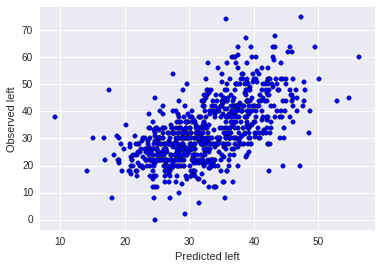

In [24]:
# Plot the results
cvsize = base.cv[('size', 'left', 0)]
cvsize.plot_observed_vs_predicted(plt.gca(), 'left')

See the other ML documentation for more information on what you can do with these two objects.

These classes also expose the data frame containing all the information you specified. You may have taken some information from Rosetta and passed in several frames of other information. It is all gathered together in a single frame, which you may want to use for other things:

In [25]:
base.dataframe.head()

,ds.index.sample_key,dynamic.FACE_P.age.v1.value,dynamic.FACE_P.gender.v1.value,dynamic.FACE.eyecolor.v1_visit1.a,dynamic.FACE.eyecolor.v1_visit1.b,dynamic.FACE.eyecolor.v1_visit1.l,dynamic.FACE.genome.v1.pc1,dynamic.FACE.genome.v1.pc2,dynamic.FACE.genome.v1.pc3,dynamic.FACE.pheno.v1.bmi,facepheno.hand.strength.left.m1,facepheno.hand.strength.right.m1,facepheno.height
564a5702c37a453053964dc1,10002_187525485,31.394947,1,NaN,NaN,NaN,43.919011,-3.060409,2.131777,-0.603972,36,28,175.00
564a5702c37a453053964db0,10342_187522718,30.792928,0,NaN,NaN,NaN,48.986257,-3.005505,-0.554261,-0.162251,48,45,177.80
564a5703c37a453053964f66,9312_187522789,26.788080,0,3.8109,2.7675,30.0927,47.179242,-3.379581,1.802628,NaN,35,38,180.34
564a5702c37a453053964d1c,10592_187526015,41.979754,1,NaN,NaN,NaN,43.580492,-1.489740,1.143202,-0.357165,34,34,159.00
564a5703c37a453053964dfa,12122_176444177,52.407211,0,NaN,NaN,NaN,-1.957145,20.539464,5.644410,-0.415386,44,50,167.00


## 11. <a id='sec10'></a>Shuffle tests
The library provides another tool for analyzing estimators. There is a shuffleRegress function which runs repeated regression tests for a given estimator and data set, with different random splits between training and test subsets. This allows you to collect statistics on the modeling, for example to get variance of the the error estimates, or to estimate a training curve.

In this example we first have some eye model boiler plate. Refer to the eye color notebook to explain the details. The point is that we are lining up the elements we need:

1. A set of covariates for the model.
2. A target for the model.
3. An estimator.
4. A data frame containing the covariates and the target.

In [26]:
import face.eyecolor.eyedata as eyedata
reload(eyedata)
import datastack.ml.shuffletest as shuffletest
data = eyedata.EyeData()
target = data.eyeval1[2]
covariates = data.getFeat(['mushsnps'], True)
cols = ['ds.index.sample_key', target] + covariates
frame = data.ndata[cols].dropna()
estimator = linear_model.Ridge()

Now that we have the ingredients in hand we run the shuffle test.

In [27]:
result = shuffletest.shuffleRegress(estimator, covariates, target, frame)
result

{'mae': [2.3371927827307859, 2.3328788093379922, 0.21037404640778334, 872],
 'mse': [10.023465645664469, 9.7734012220806292, 2.1799404690602069, 872],
 'r2': [0.33671287479109868, 0.34941854110177212, 0.12082295699754902, 872]}

For each of the criteria - mae, mse and r2 - we get the mean value, the median value, the standard deviation and the training set size.

As an example of what we can do with this, let's look at error rates for different size training sets. The function takes a "frac" parameter for the fraction of the data to put into the training set.

In [28]:
points = np.arange(0.2, 0.91, 0.02)
curve = [shuffletest.shuffleRegress(estimator, covariates, target, frame, frac=p)['r2'] for p in points]

Note that we are taking the r2 part of the results.

Each point represents a different size training set, and we get a list including mean r2 value, median r2 value, the standard deviation in the r2 values, and the training set size.

By plotting median r2 against the training set size we can see how many points we need to train this particular model.

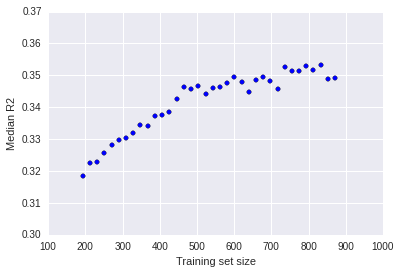

In [29]:
x = [c[3] for c in curve]
y = [c[1] for c in curve]
plt.scatter(x, y)
plt.xlabel('Training set size')
plt.ylabel('Median R2')
plt.show()